<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
import numba 
from scipy.ndimage import sobel
%matplotlib inline 
import numpy as np 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [152]:
def ramp():
    x = np.linspace(0,1,512)
    y = np.linspace(0,1,512)
    x,y = np.meshgrid(x,y)
    r = y + x**2 * np.sin(128 * np.pi * y) / 12
    
    return np.clip(r,0,1)
def z_order():
    
    x = np.arange(0,512,1).astype(int)
    y = np.arange(0,512,1).astype(int)
    r = np.zeros(x.shape + y.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            xb = format(x[i], '09b')
            yb = format(y[j], '09b')
            zb = "".join(xb_ + yb_ for xb_, yb_ in zip(xb, yb))
            r[i,j] = int(zb,2)
    
    return r

def xor():
    
    x = np.arange(0,512,1).astype(int)
    y = np.arange(0,512,1).astype(int)
    r = np.zeros(x.shape + y.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            
            r[i,j] = x[i] ^ y[j]
    
    return r
def spiral():
    x = np.linspace(-1,1,1024)
    y = np.linspace(-1,1,1024)
    x,y = np.meshgrid(x,y)
    r = np.arcsin(np.sin(4 * np.pi * (x**2 + y**2) + np.arctan2(y,x)))
    
    return r

def sine_product():
    x = np.linspace(-np.pi, np.pi,1024)
    y = np.linspace(-np.pi, np.pi,1024)
    x,y = np.meshgrid(x,y)
    r = np.sin(x) * np.sin(y) + np.sin(3*x) * np.sin(3*y)
    
    return r


@numba.jit(nopython=True)
def in_main_cardioid(c):
    q = (c.real - 1/4)**2 + c.imag**2
    return q*(q + (c.real - 1/4)) <= c.imag**2/4

@numba.jit(nopython=True)
def in_period2bulb(c):
    return (c.real + 1)**2 + c.imag**2 <= 1/16

@numba.vectorize(nopython=True)
def mandelbrot(c, maxiter):
    # --> Check if point is in main cardioid.
    if in_main_cardioid(c): return True
    if in_period2bulb(c): return True
    
    # --> If not, check if it is nonetheless in the
    #     Mandelbrot set.
    z = 0
    for i in range(maxiter):
        if np.abs(z) > 2:
            return False
        z = z**2 + c

    return True
@numba.jit(nopython=True, parallel=True)
def trajectory(c, maxiter):
    # --> Compute trajectory.
    z = np.zeros((maxiter, 2), dtype=numba.float64)
    
    x, y = c.real, c.imag
    z[0] = x, y
    x2, y2 = x*x, y*y
    
    for i in range(1, maxiter):
        
        # --> Update point.
        y = 2*x*y + c.imag
        x = x2 - y2 + c.real
        x2, y2 = x*x, y*y
        
        z[i] = x, y

        # --> Check bailout condition.
        if (x2 + y2) > 4:
            break

    return z[:i+1]
def uniform_sampling():

    # --> Uniform sampling in disk or radius 2.
    r = np.random.uniform(0, 2)
    theta = np.random.uniform(-np.pi, np.pi)
    c = r * np.exp(1j*theta)
    
    # --> Accept/Reject c.
    while in_main_cardioid(c) or in_period2bulb(c):
        return uniform_sampling()
    else:
        return c
def sample_trajectory(maxiter, get_new_sample):

    rejected = True
    
    # --> Sample new trajectory if needed.
    while rejected:
        # --> Sample new c value.
        c = get_new_sample()
        
        # --> New candidate trajectory.
        z = trajectory(c, maxiter)
        
        # --> Accept/Reject trajectory.
        rejected = len(z) == maxiter
    else:
        return z
def generate_data(n, maxiter, get_new_sample):
    
    # --> Initial trajectory.
    z = sample_trajectory(maxiter, get_new_sample)
    
    # --> Add new trajectories to the dataset.
    #     We do so until we have at least n points
    #     in the dataset.
    while len(z) < n:
        k = len(z)
        z = np.append(z, sample_trajectory(maxiter, get_new_sample), axis=0)
    else:
        return z
def compute_image(
    n,                               # Number of points to include in the dataset.
    maxiter=100,                     # Maximum number of iterations.
    get_new_sample=uniform_sampling, # How to sample c.
    nx=301, ny=301):                 # Resolution of the final image.
    
    # --> Generate data.
    data = generate_data(n, maxiter, get_new_sample)
    
    # --> Generate image.
    cr, ci = np.linspace(-2, 2, nx), np.linspace(-2, 2, ny)
    H, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=[cr, ci])
    
    return H
def reject(c):
    return in_main_cardioid(c) or in_period2bulb(c) or np.abs(c)>2

def smart_sampling(cs, Δx, Δy):

    # --> Perturbation to be added to the sampled point.
    Δcr = np.random.uniform(-Δx/2, Δx/2)
    Δci = np.random.uniform(-Δy/2, Δy/2)
    
    Δc = Δcr + 1j*Δci
    
    # --> Value of c to be tested.
    idx = np.random.randint(len(cs))
    c = cs[idx] + Δc
    
    while reject(c):
        return smart_sampling(cs, Δx, Δy)
    else:
        return c

# --> Complex plane.
nx, ny = 3001, 2501
cr = np.linspace(-2.25, 0.75, nx)
ci = np.linspace(-1.25, 1.25, ny)
c = cr[:, None] + 1j*ci[None, :]

# --> Compute the Mandelbrot set.
M = mandelbrot(c, maxiter)

# --> Compute its edges.
edges = np.abs(sobel(M, axis=0)) + np.abs(sobel(M, axis=1))
# --> Points from which to sample.
cs = c[edges == True].ravel()

# --> Scale of the perturbation to be added.
Δx, Δy = cr[1] - cr[0], ci[1]-ci[0]


In [ ]:
# 10^7 might take a while. You can do 10^6 for a faster result
buddhabrot = compute_image(n = 10**7, maxiter=1000, get_new_sample=lambda : smart_sampling(cs, Δx, Δy))
buddhabrot /= buddhabrot.max()
buddhabrot[:,:buddhabrot.shape[1] // 2]  = 1 - buddhabrot[:,:buddhabrot.shape[1] // 2] 

In [150]:
def cmap_checker(cmap):
    fig,ax = plt.subplots(figsize=(15,10),nrows=2,ncols=3)
    axs = np.ndarray.flatten(ax)
    axs[0].imshow(ramp(),cmap=cmap)
    axs[1].imshow(z_order(),cmap=cmap)
    axs[2].imshow(xor(),cmap=cmap)
    axs[3].imshow(spiral(),cmap=cmap)
    axs[4].imshow(sine_product(),cmap=cmap)
    axs[5].imshow(buddhabrot,cmap=cmap)
    axs[5].set_xlim(50,250)
    axs[5].set_ylim(25,200)

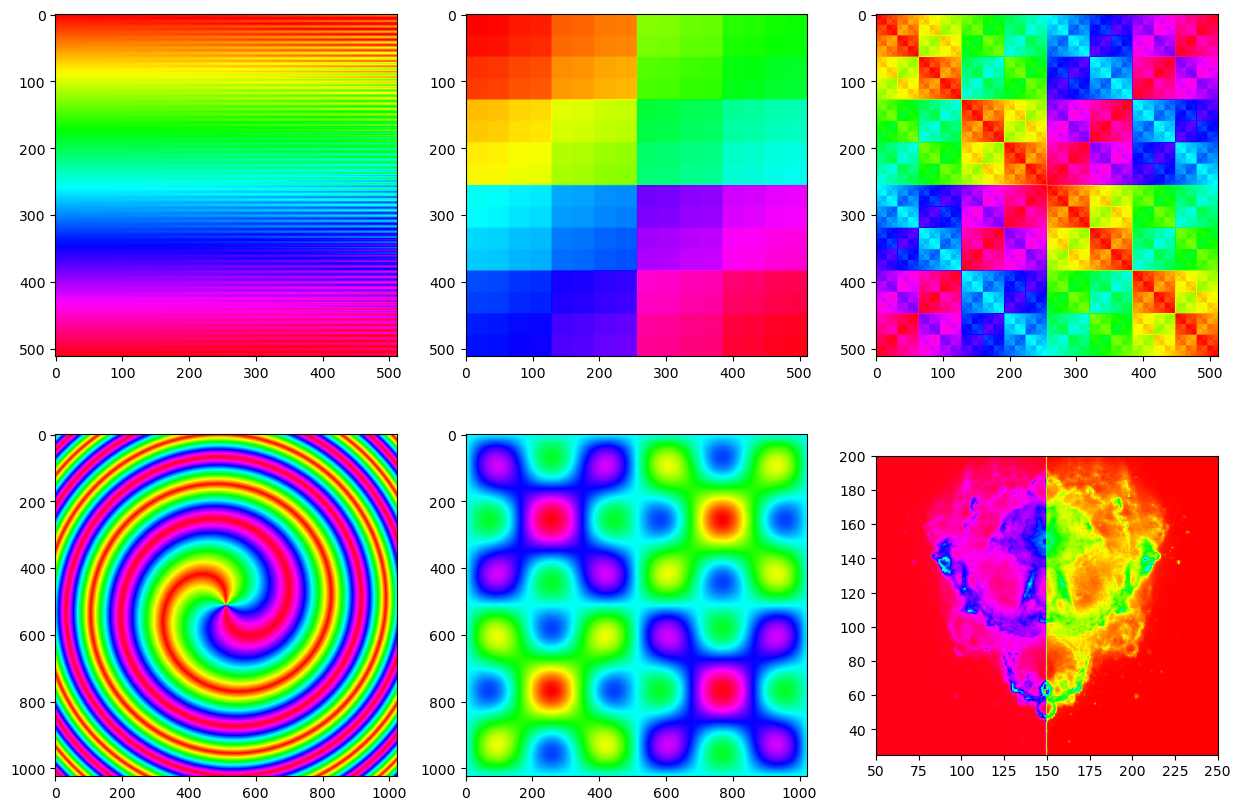

In [151]:
cmap_checker('hsv')
